## savgol video {.unnumbered}

Import packages and stuff.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()  # datetime converter for a matplotlib
import seaborn as sns
sns.set(style="ticks", font_scale=1.5)
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import scipy as sp
import json
import requests
import os
import subprocess
from tqdm import tqdm
from scipy import signal
from scipy.signal import savgol_filter


# avoid "SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame."
pd.options.mode.chained_assignment = None  # default='warn'

Download  data from the [IMS](https://ims.gov.il/en/data_gov){target="_blank"} using an API.

In [5]:
# read token from file
with open('../archive/IMS-token.txt', 'r') as file:
    TOKEN = file.readline()
# 28 = SHANI station
STATION_NUM = 28
start = "2022/01/01"
end = "2022/01/07"
filename = 'shani_2022_january.json'

# check if the JSON file already exists
# if so, then load file
if os.path.exists(filename):
    with open(filename, 'r') as json_file:
        data = json.load(json_file)
else:
    # make the API request if the file doesn't exist
    url = f"https://api.ims.gov.il/v1/envista/stations/{STATION_NUM}/data/?from={start}&to={end}"
    headers = {'Authorization': f'ApiToken {TOKEN}'}
    response = requests.get(url, headers=headers)
    data = json.loads(response.text.encode('utf8'))
    
    # save the JSON data to a file
    with open(filename, 'w') as json_file:
        json.dump(data, json_file)
# show data to see if it's alright
# data

Load and process data.

In [6]:
df = pd.json_normalize(data['data'],record_path=['channels'], meta=['datetime'])
df['date'] = (pd.to_datetime(df['datetime'])
                .dt.tz_localize(None)  # ignores time zone information
             )
df = df.pivot(index='date', columns='name', values='value')
df

name,Grad,RH,Rain,STDwd,TD,TDmax,TDmin,TG,TW,Time,WD,WDmax,WS,WS1mm,WSmax,Ws10mm
date,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,0.0,77.0,0.0,10.3,11.2,11.2,11.1,10.7,-9999.0,2354.0,75.0,64.0,5.0,6.0,7.0,5.5
2022-01-01 00:10:00,0.0,77.0,0.0,11.2,11.2,11.2,11.1,10.8,-9999.0,1.0,77.0,84.0,4.7,5.5,6.6,4.9
2022-01-01 00:20:00,0.0,75.0,0.0,10.0,11.4,11.5,11.2,10.9,-9999.0,20.0,80.0,83.0,5.1,6.2,8.0,5.1
2022-01-01 00:30:00,0.0,74.0,0.0,9.6,11.5,11.5,11.4,11.0,-9999.0,22.0,76.0,74.0,4.8,5.8,7.3,5.0
2022-01-01 00:40:00,0.0,73.0,0.0,9.1,11.6,11.7,11.5,11.1,-9999.0,34.0,74.0,64.0,4.8,5.7,7.2,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-06 23:10:00,0.0,36.0,0.0,16.1,11.6,12.0,11.1,6.8,-9999.0,2310.0,144.0,126.0,0.7,1.6,2.0,0.7
2022-01-06 23:20:00,0.0,35.0,0.0,10.1,12.1,12.3,11.9,6.3,-9999.0,2320.0,118.0,116.0,1.5,1.9,2.3,1.5
2022-01-06 23:30:00,0.0,36.0,0.0,7.1,12.4,12.6,11.9,7.3,-9999.0,2330.0,113.0,116.0,2.5,3.0,3.3,2.5


Define useful functions.

In [7]:
def concise(ax):
    """
    Let python choose the best xtick labels for you
    """
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

# dirty trick to have dates in the middle of the 24-hour period
# make minor ticks in the middle, put the labels there!
# from https://matplotlib.org/stable/gallery/ticks/centered_ticklabels.html

def center_dates(ax):
    # show day of the month + month abbreviation. see full option list here:
    # https://strftime.org
    date_form = DateFormatter("%d %b")
    # major ticks at midnight, every day
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(date_form)
    # minor ticks at noon, every day
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[12]))
    # erase major tick labels
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    # set minor tick labels as define above
    ax.xaxis.set_minor_formatter(date_form)
    # completely erase minor ticks, center tick labels
    for tick in ax.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
        tick.label1.set_horizontalalignment('center')

def center_dates_two_panels(ax0, ax1):
    # show day of the month + month abbreviation. see full option list here:
    date_form = DateFormatter("%d %b")
    # major ticks at midnight, every day
    ax0.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax1.xaxis.set_major_formatter(date_form)
    # minor ticks at noon, every day
    ax1.xaxis.set_minor_locator(mdates.HourLocator(byhour=[12]))
    # erase major tick labels
    ax1.xaxis.set_major_formatter(ticker.NullFormatter())
    # set minor tick labels as define above
    ax1.xaxis.set_minor_formatter(date_form)
    # completely erase minor ticks, center tick labels
    for tick in ax0.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
    for tick in ax1.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
        tick.label1.set_horizontalalignment('center')

We don't need the full month, let's cut the dataframe to fewer days.

In [8]:
start = "2022-01-01 00:00:00"
end = "2022-01-06 23:50:00"
df = df.loc[start:end]

We now redefine a narrower window, this will be the graph's xlimits. We leave the dataframe as is, because we will need some data outside the graph's limits.

In [9]:
start = "2022-01-02 00:00:00"
end = "2022-01-05 23:50:00"

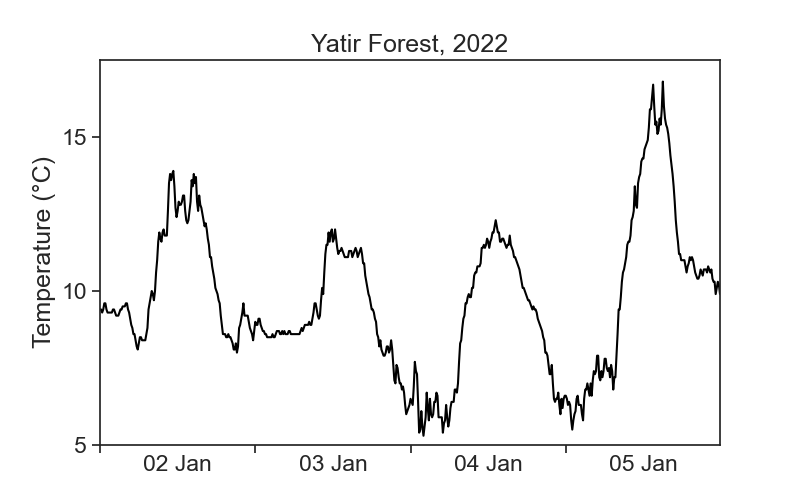

In [10]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(df.loc[start:end, 'TD'], color='black')
ax.set(ylim=[5, 17.5],
       xlim=[start, end],
       ylabel="Temperature (°C)",
       title="Yatir Forest, 2022",
       yticks=[5,10,15])
center_dates(ax)
# fig.savefig("sliding_YF_temperature_2022.png")

Looks good. Let's move on.

## Savgol filter

In [11]:
# Function to fit and get polynomial values
def fit_polynomial(x, y, degree):
    coeffs = np.polyfit(x, y, degree)
    poly = np.poly1d(coeffs)
    return poly(x), coeffs

# Function to fit and get polynomial values
def poly_coeffs(x, y, degree):
    coeffs = np.polyfit(x, y, degree)
    return coeffs

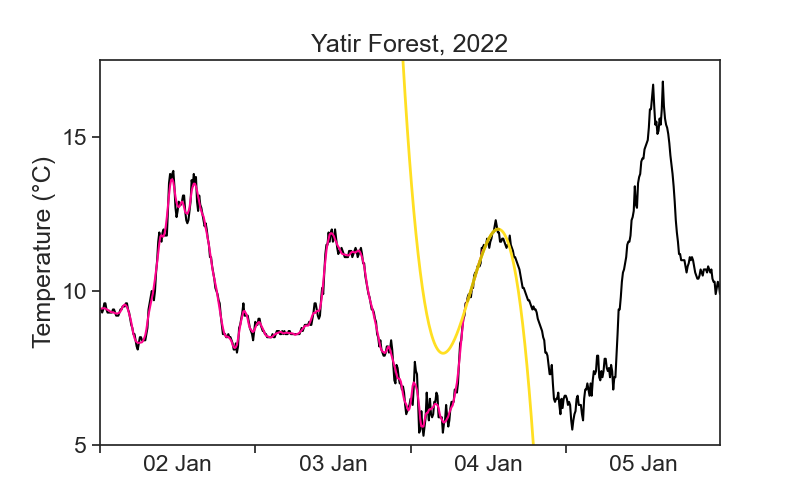

In [26]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(df.loc[start:end, 'TD'], color='black')

sg = savgol_filter(df['TD'], 13, 2)

i = 500
ax.plot(df.index[:i], sg[:i], color='xkcd:hot pink')

window_pts = 31
p_order = 3

window_x = np.arange(i - window_pts // 2, i + window_pts // 2)
window_y = df['TD'][i - window_pts // 2:i + window_pts // 2]

# Fit and plot polynomial inside the window
fitted_y, coeffs = fit_polynomial(window_x, window_y, p_order)

whole_x = np.arange(len(df))
whole_y = df['TD'].values
poly = np.poly1d(coeffs)
whole_poly = poly(whole_x)

ax.plot(df.index, whole_poly, color='xkcd:sun yellow', lw=2)
# ax.plot(df.index[window_x], fitted_y, color='0.8', lw=3)
ax.plot(df.index[window_x], fitted_y, color='xkcd:mustard', lw=2)



ax.set(ylim=[5, 17.5],
       xlim=[start, end],
       ylabel="Temperature (°C)",
       title="Yatir Forest, 2022",
       yticks=[5,10,15])
center_dates(ax)
# fig.savefig("sliding_YF_temperature_2022.png")






In [36]:
p_order = 3

100%|█████████▉| 634/635 [13:07<00:01,  1.24s/iteration]


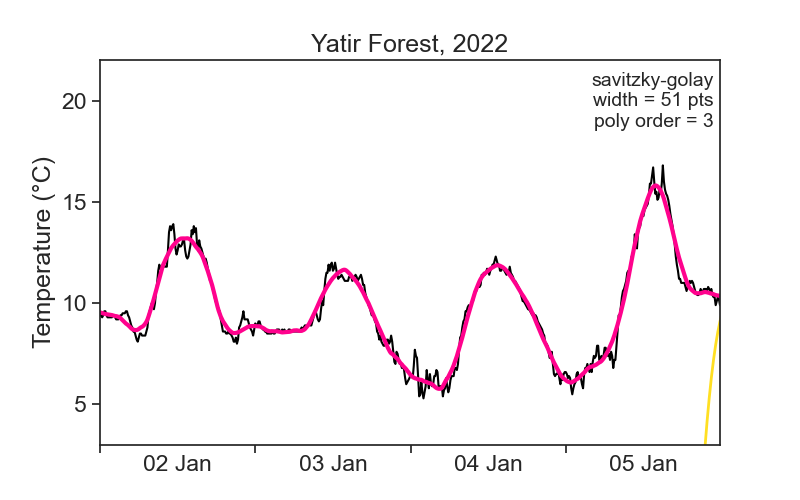

In [27]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8,5))

class Lines:
    """
    empty class, later will be populated with graph objects.
    this is useful to draw and erase lines on demand.
    """
    pass
lines = Lines()

# set graph y limits
ylim = [3, 22]
# choose here windown width in minutes
window_width_min = 500.0
window_width_min_integer = int(window_width_min)  # same but integer
window_width_int = int(window_width_min // 10 + 1)  # window width in points
N = len(df)  # df length
t_swipe = pd.date_range(start=pd.to_datetime(start) - pd.Timedelta(minutes=window_width_min) - pd.Timedelta(minutes=30),
                        end=pd.to_datetime(end) + pd.Timedelta(minutes=60),
                        freq="10min")
# starting time
t0 = t_swipe[0]
ind0 = df.index.get_loc(t0) + window_width_int//2 + 1
# show sliding window on the top panel as a light blue shade
lines.fill_bet = ax.fill_between([t0, t0 + pd.Timedelta(minutes=window_width_min)],
                                           y1=ylim[0], y2=ylim[1], alpha=0.1, zorder=-1)

sg = savgol_filter(df['TD'], window_width_int, p_order)
df.loc[:, 'sg'] = sg 
# plot temperature
ax.plot(df.loc[start:end, 'TD'], color="black")

# define x,y data inside window to execute polyfit on
window_x = np.arange(ind0 - window_width_int // 2, ind0 + window_width_int // 2)
window_y = df['TD'][ind0 - window_width_int // 2:ind0 + window_width_int // 2].values
# fit and plot polynomial inside the window
fitted_y, coeffs = fit_polynomial(window_x, window_y, p_order)
# get x,y data for the whole array
whole_x = np.arange(len(df))
whole_y = df['TD'].values
poly = np.poly1d(coeffs)
whole_poly = poly(whole_x)

# calculate the middle of the sliding window
window_middle = t0 + pd.Timedelta(minutes=window_width_min/2)
# plot a pink line showing the result of the moving average
# from the beginning to the middle of the sliding window
lines.pink_line, = ax.plot(df.loc[start:window_middle, 'sg'], color="xkcd:hot pink", lw=3)

lines.poly_all, = ax.plot(df.index, whole_poly, color='xkcd:sun yellow', lw=2)
lines.poly_window, = ax.plot(df.index[window_x], fitted_y, color='xkcd:mustard', lw=2)

# emphasize the location of the middle on the window with a circle
lines.pink_circle, = ax.plot([window_middle], [df.loc[window_middle, 'sg']],
         marker='o', markerfacecolor="None", markeredgecolor="xkcd:dark pink", markeredgewidth=2,
         markersize=8)
# some explanation
ax.text(0.99, 0.97, f"savitzky-golay\nwidth = {window_width_int:.0f} pts\npoly order = {p_order}", transform=ax.transAxes,
         horizontalalignment='right', verticalalignment='top',
         fontsize=14)
# axis tweaking
ax.set(ylim=ylim,
        xlim=[start, end],
        ylabel="Temperature (°C)",
        yticks=[5,10,15,20],
        title="Yatir Forest, 2022")
# adjust dates on both panels as defined before
center_dates(ax)

def update_swipe(k, lines):
    """
    updates both panels, given the index k along which the window is sliding
    """
    # left side of the sliding window
    t0 = t_swipe[k]
    # middle position
    window_middle = t0 + pd.Timedelta(minutes=window_width_min/2)
    ind0 = df.index.get_loc(window_middle)
    # erase previous blue shade on the top graph
    lines.fill_bet.remove()
    # fill again the blue shade in the updated window position
    lines.fill_bet = ax.fill_between([t0, t0 + pd.Timedelta(minutes=window_width_min)],
                                               y1=ylim[0], y2=ylim[1], alpha=0.1, zorder=-1, color="tab:blue")
    # update pink curve
    lines.pink_line.set_data(df[start:window_middle].index,
                             df.loc[start:window_middle, 'sg'].values)
    # update pink circle
    lines.pink_circle.set_data([window_middle], [df.loc[window_middle, 'sg']])
    # define x,y data inside window to execute polyfit on
    
    window_x = np.arange(ind0 - window_width_int // 2, ind0 + window_width_int // 2)
    window_y = df['TD'][ind0 - window_width_int // 2:ind0 + window_width_int // 2]
    # fit and plot polynomial inside the window
    fitted_y, coeffs = fit_polynomial(window_x, window_y, p_order)
    poly = np.poly1d(coeffs)
    whole_poly = poly(whole_x)
    lines.poly_all.set_data(df.index, whole_poly)
    lines.poly_window.set_data(df.index[window_x], fitted_y)

fig.savefig(f"pngs/savgol{window_width_int}/savgol_zero.png", dpi=600)

# create a tqdm progress bar
progress_bar = tqdm(total=len(t_swipe), unit="iteration")
# loop over all sliding indices, update graph and then save it
for fignum, i in enumerate(np.arange(0, len(t_swipe)-1, 1)):
    update_swipe(i, lines)
    fig.savefig(f"pngs/savgol{window_width_int}/savgol_{window_width_int}_{fignum:03}.png", dpi=600)
    # update the progress bar
    progress_bar.update(1)
# close the progress bar
progress_bar.close()

Combine all saved images into one mp4 video.

In [28]:
# Define the path to your PNG images
pngs_path = f"pngs/savgol51"
pngs_name = f"savgol_51_%03d.png"

# Define the output video file path
video_output = f"output_savgol51.mp4"

# Use ffmpeg to create a video from PNG images
# desired framerate. choose 24 if you don't know what to do
fr = 12
# run command
ffmpeg_cmd = f"ffmpeg -framerate {fr} -i {pngs_path}/{pngs_name} -c:v libx264 -vf fps={fr} {video_output}"
subprocess.run(ffmpeg_cmd, shell=True)

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.1.0.2.5)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/6.1.1_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr 

CompletedProcess(args='ffmpeg -framerate 12 -i pngs/savgol51/savgol_51_%03d.png -c:v libx264 -vf fps=12 output_savgol51.mp4', returncode=0)